### RETAIL E-COMMERCE

#### Group Activity  - December 2022

##### DSC43 - Srivatsa / kiran sai  / MOHAMMED TAHER

### PROBLEM STATEMENT

###### Schuster would like to better understand the customers’ payment behaviour based on their past payment patterns (customer segmentation).

###### Using historical information, it wants to be able to predict the likelihood of delayed payment against open invoices from its customers.

##### It wants to use this information so that collectors can prioritise their work in following up with customers beforehand to get the payments on time.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.0f' % x)

### UNDERSTAND DATA

###### We will need to do the prediction on Open Invoices Data 
So let us identify the relevent set of Columns present in Received_Payments  

In [3]:
### Read Data to Frame 
reData = pd.read_csv("Received_Payments_Data.csv")
####invData = pd.read_csv("open_invoice_data2.csv" , encoding = "ISO-8859-1")

In [4]:
reData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

##### There are Date columns as Object - lets convert them to Date 

In [5]:
reData["RECEIPT_DATE"] = pd.to_datetime(reData["RECEIPT_DATE"], format='%d-%b-%y')
reData["INVOICE_CREATION_DATE"] = pd.to_datetime(reData["INVOICE_CREATION_DATE"], format='%d-%b-%y')
reData["DUE_DATE"] = pd.to_datetime(reData["DUE_DATE"], format='%d-%b-%y')

In [6]:
reData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         93937 non-null  object        
 1   CUSTOMER_NAME          93937 non-null  object        
 2   CUSTOMER_NUMBER        93937 non-null  int64         
 3   RECEIPT_DOC_NO         93908 non-null  float64       
 4   RECEIPT_DATE           93937 non-null  datetime64[ns]
 5   CLASS                  93937 non-null  object        
 6   CURRENCY_CODE          93937 non-null  object        
 7   Local Amount           93937 non-null  float64       
 8   USD Amount             93937 non-null  float64       
 9   INVOICE_ALLOCATED      93937 non-null  object        
 10  INVOICE_CREATION_DATE  93937 non-null  datetime64[ns]
 11  DUE_DATE               93937 non-null  datetime64[ns]
 12  PAYMENT_TERM           93937 non-null  object        
 13  I

In [7]:
### Drop Columns with Missing Values (RECEIPT_DOC_NO) and other not Required
reData = reData.drop(columns=['RECEIPT_DOC_NO','PAYMENT_TERM','CLASS','RECEIPT_METHOD','Local Amount','INVOICE_ALLOCATED'])
reData.shape

(93937, 10)

In [8]:
reData.head()

,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,C EA Corp,37403,2021-04-20,USD,101019,2020-11-02,2020-12-30,INV,AED,Non Goods
1,RADW Corp,4003,2021-01-31,SAR,48990,2020-12-29,2021-01-28,INV,SAR,Non Goods
2,RADW Corp,4003,2021-01-31,SAR,41992,2021-01-30,2021-03-01,INV,SAR,Non Goods
3,FARO Corp,1409,2021-01-31,SAR,41992,2020-12-15,2021-01-14,INV,SAR,Non Goods
4,RADW Corp,4003,2021-01-31,SAR,41992,2020-12-15,2021-01-14,INV,SAR,Non Goods


In [9]:
reData.INVOICE_TYPE.value_counts()

Goods        66715
Non Goods    27222
Name: INVOICE_TYPE, dtype: int64

##### Lets Delete the Current PAYMENT_TERM - Which has too many values and Create a New Payment_term based on Days Difference between invoice data and Due date 

In [10]:
reData["PAY_TERM"] = (reData["DUE_DATE"] - reData["INVOICE_CREATION_DATE"]).dt.days

#### Target Variable is to be determined - based on if Receipt Date is < Due Date

In [11]:
## Function to Return 0 or 1 
def isDelayed(RD , DD) :
    if (RD > DD):
        return 1 
    else:
        return 0


In [12]:
reData["DELAYED"] = reData.apply(lambda x: isDelayed( x['RECEIPT_DATE'], x['DUE_DATE'] ), axis=1)

In [13]:
## DAYS BETWEEN INVOiCE CREATION AND ACTUAL PAYMENT -- USED For Customer Segmentation
reData["PAY_DAYS"] = (reData['RECEIPT_DATE'] - reData['INVOICE_CREATION_DATE']).dt.days

In [14]:
### Rename USD Amount to USD_AMT
reData = reData.rename(columns={'USD Amount': 'USD_AMT'}) 

In [15]:
reData.head()

,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CURRENCY_CODE,USD_AMT,INVOICE_CREATION_DATE,DUE_DATE,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,PAY_TERM,DELAYED,PAY_DAYS
0,C EA Corp,37403,2021-04-20,USD,101019,2020-11-02,2020-12-30,INV,AED,Non Goods,58,1,169
1,RADW Corp,4003,2021-01-31,SAR,48990,2020-12-29,2021-01-28,INV,SAR,Non Goods,30,1,33
2,RADW Corp,4003,2021-01-31,SAR,41992,2021-01-30,2021-03-01,INV,SAR,Non Goods,30,0,1
3,FARO Corp,1409,2021-01-31,SAR,41992,2020-12-15,2021-01-14,INV,SAR,Non Goods,30,1,47
4,RADW Corp,4003,2021-01-31,SAR,41992,2020-12-15,2021-01-14,INV,SAR,Non Goods,30,1,47


###### PAY_TERM Cannot be Negative - that is Due Data cannot be before Invoice is generated 

In [16]:
reData = reData[reData.PAY_TERM > 0]

In [17]:
reData.shape

(81077, 13)

##### USD_AMT Cannot be Zero - Lets Eliminate the Bottom 02  and Top 2 Quantile 

In [18]:
reData = reData[reData['USD_AMT'] > reData['USD_AMT'].quantile(.02)]
reData = reData[reData['USD_AMT'] < reData['USD_AMT'].quantile(.98)]

<AxesSubplot:>

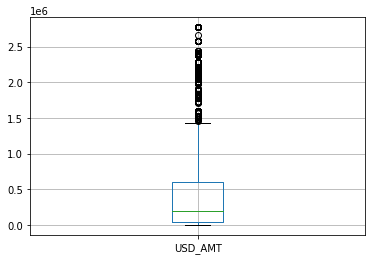

In [19]:
reData.boxplot(column=['USD_AMT'])

In [20]:
reData['USD_AMT'].describe()

count     77828
mean     412280
std      510678
min         638
25%       42006
50%      194951
75%      597764
max     2771600
Name: USD_AMT, dtype: float64

In [21]:
### Check # of Unique Customers 
reData[['CUSTOMER_NAME','CUSTOMER_NUMBER']].nunique()

CUSTOMER_NAME      582
CUSTOMER_NUMBER    859
dtype: int64

#### CREATE CUSTOMER SEGMENTS BASED ON PAY_TERM - Average / Std Deviation

In [22]:
csMeanPay = reData.groupby('CUSTOMER_NAME')['PAY_TERM'].mean()  ##Using PAY_TERM / PAY_DAYS

In [23]:
csSDPay = reData.groupby('CUSTOMER_NAME')['PAY_TERM'].std()

In [24]:
csDF = pd.merge(csMeanPay, csSDPay, on='CUSTOMER_NAME' , suffixes=('_MN', '_SD') ,how='inner' )

In [25]:
csDF.reset_index()

,CUSTOMER_NAME,PAY_TERM_MN,PAY_TERM_SD
0,3D D Corp,35,11
1,6TH Corp,78,7
2,A3 D Corp,27,2
3,ABC Corp,90,0
4,ABDU Corp,72,30
...,...,...,...
577,YOUS Corp,90,0
578,ZAHR Corp,96,18
579,ZAIN Corp,40,7
580,ZERO Corp,30,1


In [26]:
csDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582 entries, 3D D Corp to ZV F Corp
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PAY_TERM_MN  582 non-null    float64
 1   PAY_TERM_SD  506 non-null    float64
dtypes: float64(2)
memory usage: 13.6+ KB


In [27]:
csDF['PAY_TERM_SD'] = csDF['PAY_TERM_SD'].replace(np.nan,0) 

In [28]:
csDF.head()

,PAY_TERM_MN,PAY_TERM_SD
CUSTOMER_NAME,,
3D D Corp,35,11
6TH Corp,78,7
A3 D Corp,27,2
ABC Corp,90,0
ABDU Corp,72,30


In [29]:
csDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582 entries, 3D D Corp to ZV F Corp
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PAY_TERM_MN  582 non-null    float64
 1   PAY_TERM_SD  582 non-null    float64
dtypes: float64(2)
memory usage: 13.6+ KB


In [30]:
### rescaling
csDF_for_scaling = csDF[['PAY_TERM_MN', 'PAY_TERM_SD']]

# instantiate
csScaler = StandardScaler()

# fit_transform
csDF_Scaled = csScaler.fit_transform(csDF_for_scaling)
csDF_Scaled.shape

(582, 2)

In [31]:
csDF_Scaled = pd.DataFrame(csDF_Scaled)
csDF_Scaled.columns = ['CS_Mean', 'CS_STDEV']
csDF_Scaled.head()

,CS_Mean,CS_STDEV
0,-1,1
1,1,0
2,-1,-0
3,2,-1
4,1,3


In [32]:
csDF_Scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CS_Mean   582 non-null    float64
 1   CS_STDEV  582 non-null    float64
dtypes: float64(2)
memory usage: 9.2 KB


###### Determine optimum K value from Silhoutte Analysis 

In [33]:
# silhouette analysis
range_n_clusters = [2,3, 4, 5, 6, 7, 8,9]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(csDF_Scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(csDF_Scaled, cluster_labels)
    print(f"For {num_clusters} the silhouette score is {silhouette_avg}")    
    

For 2 the silhouette score is 0.4666473910165313
For 3 the silhouette score is 0.4812052358855987
For 4 the silhouette score is 0.43806626773723034
For 5 the silhouette score is 0.5058752273784887
For 6 the silhouette score is 0.511560604865032
For 7 the silhouette score is 0.5191704524574663
For 8 the silhouette score is 0.5141224222718157
For 9 the silhouette score is 0.5572419265132538


In [34]:
# final model with k=5
kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(csDF_Scaled)

KMeans(max_iter=50, n_clusters=5)

In [35]:
# assign the label
csDF['cluster_id'] = kmeans.labels_
csDF.head()

,PAY_TERM_MN,PAY_TERM_SD,cluster_id
CUSTOMER_NAME,,,
3D D Corp,35,11,0
6TH Corp,78,7,3
A3 D Corp,27,2,2
ABC Corp,90,0,3
ABDU Corp,72,30,4


In [36]:
csDF.cluster_id.value_counts()

1    182
0    143
2    139
3     66
4     52
Name: cluster_id, dtype: int64

##### MERGE WITH reDATA so that we have Customer Segmentation with origianl Frame 

In [37]:
reData = reData.merge(csDF, how='left' , on='CUSTOMER_NAME' )

In [38]:
reData.tail()

,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CURRENCY_CODE,USD_AMT,INVOICE_CREATION_DATE,DUE_DATE,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,PAY_TERM,DELAYED,PAY_DAYS,PAY_TERM_MN,PAY_TERM_SD,cluster_id
77823,PEAR Corp,21144,2021-04-01,USD,59914,2021-02-07,2021-04-05,INV,USD,Goods,57,0,53,56,5,1
77824,PEAR Corp,21144,2021-04-01,USD,59914,2021-01-11,2021-03-12,INV,USD,Goods,60,1,80,56,5,1
77825,PEAR Corp,21144,2021-04-01,USD,59914,2020-12-21,2021-02-13,INV,USD,Goods,54,1,101,56,5,1
77826,NAMS Corp,21145,2021-04-01,AED,23574,2021-01-24,2021-03-24,INV,AED,Goods,59,1,67,65,13,0
77827,SENS Corp,48486,2021-04-08,AED,1443,2021-02-16,2021-03-30,INV,AED,Goods,42,1,51,49,6,0


In [39]:
def cSegments(seg_num):
    if seg_num == 0 :
        return 'A' 
    elif seg_num == 1 :
        return 'B'
    elif seg_num == 2 :
        return 'C' 
    elif seg_num == 3 :
        return 'D'
    else :
        return 'E'
    

In [40]:
reData["CUST_SEGMENT"] = reData["cluster_id"].apply(lambda x: cSegments(x))

##### Let's Check each of the Variables against Target 


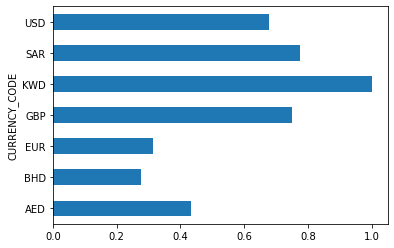

In [41]:
#plot the bar graph of Currency Code Agaianst Target (Delayed)
reData.groupby("CURRENCY_CODE")["DELAYED"].mean().plot.barh()
plt.show()

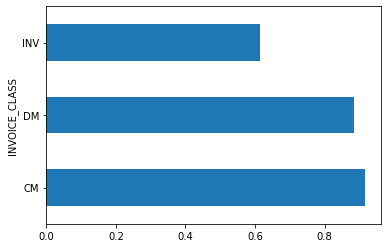

In [42]:
#plot the bar graph of Currency Code Agaianst Target (Delayed)
reData.groupby("INVOICE_CLASS")["DELAYED"].mean().plot.barh()
plt.show()


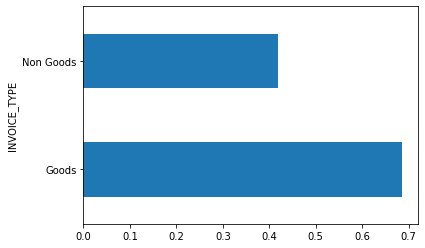

In [43]:
#plot the bar graph of Currency Code Agaianst Target (Delayed)
reData.groupby("INVOICE_TYPE")["DELAYED"].mean().plot.barh()
plt.show()

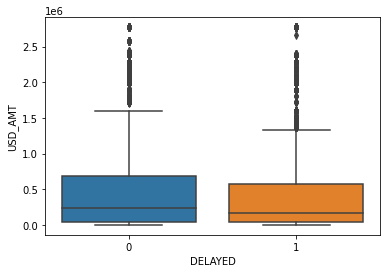

In [44]:
#plot the box plot of USD Amout for Target (Delayed)
sns.boxplot(data=reData, x="DELAYED", y="USD_AMT")
plt.show()

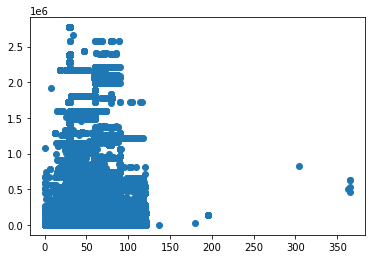

In [45]:
### 
#plot the scatter plot of USD Amount and PAY_TERM 
plt.scatter(reData.PAY_TERM, reData['USD_AMT'])
plt.show()

In [46]:
reData.head()

,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CURRENCY_CODE,USD_AMT,INVOICE_CREATION_DATE,DUE_DATE,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,PAY_TERM,DELAYED,PAY_DAYS,PAY_TERM_MN,PAY_TERM_SD,cluster_id,CUST_SEGMENT
0,C EA Corp,37403,2021-04-20,USD,101019,2020-11-02,2020-12-30,INV,AED,Non Goods,58,1,169,56,4,1,B
1,RADW Corp,4003,2021-01-31,SAR,48990,2020-12-29,2021-01-28,INV,SAR,Non Goods,30,1,33,41,19,4,E
2,RADW Corp,4003,2021-01-31,SAR,41992,2021-01-30,2021-03-01,INV,SAR,Non Goods,30,0,1,41,19,4,E
3,FARO Corp,1409,2021-01-31,SAR,41992,2020-12-15,2021-01-14,INV,SAR,Non Goods,30,1,47,47,18,4,E
4,RADW Corp,4003,2021-01-31,SAR,41992,2020-12-15,2021-01-14,INV,SAR,Non Goods,30,1,47,41,19,4,E


In [47]:
### Lets Retain only the Required Columns
reqRetailCols = ['CUSTOMER_NAME','CURRENCY_CODE','USD_AMT','INVOICE_CLASS','CUST_SEGMENT', 'PAY_TERM','DELAYED']

In [48]:
reDF = reData[reqRetailCols]

In [49]:
reDF.head()

,CUSTOMER_NAME,CURRENCY_CODE,USD_AMT,INVOICE_CLASS,CUST_SEGMENT,PAY_TERM,DELAYED
0,C EA Corp,USD,101019,INV,B,58,1
1,RADW Corp,SAR,48990,INV,E,30,1
2,RADW Corp,SAR,41992,INV,E,30,0
3,FARO Corp,SAR,41992,INV,E,30,1
4,RADW Corp,SAR,41992,INV,E,30,1


In [50]:
reDF.shape

(77828, 7)

### INITIATE PREP FOR MODELING

##### 1. CREATE DUMMY VARIABLES FOR CATEGORICAL VARABLES 

In [51]:
dum_DF = pd.get_dummies(reDF[['CURRENCY_CODE','INVOICE_CLASS','CUST_SEGMENT']], drop_first=True)


In [52]:
dum_DF.head()

,CURRENCY_CODE_BHD,CURRENCY_CODE_EUR,CURRENCY_CODE_GBP,CURRENCY_CODE_KWD,CURRENCY_CODE_SAR,CURRENCY_CODE_USD,INVOICE_CLASS_DM,INVOICE_CLASS_INV,CUST_SEGMENT_B,CUST_SEGMENT_C,CUST_SEGMENT_D,CUST_SEGMENT_E
0,0,0,0,0,0,1,0,1,1,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,1
2,0,0,0,0,1,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,1,0,0,1,0,0,0,1


In [53]:
## Merging with the Original DataFrame 
reDF=pd.concat([reDF, dum_DF], axis=1)
reDF.head()

,CUSTOMER_NAME,CURRENCY_CODE,USD_AMT,INVOICE_CLASS,CUST_SEGMENT,PAY_TERM,DELAYED,CURRENCY_CODE_BHD,CURRENCY_CODE_EUR,CURRENCY_CODE_GBP,CURRENCY_CODE_KWD,CURRENCY_CODE_SAR,CURRENCY_CODE_USD,INVOICE_CLASS_DM,INVOICE_CLASS_INV,CUST_SEGMENT_B,CUST_SEGMENT_C,CUST_SEGMENT_D,CUST_SEGMENT_E
0,C EA Corp,USD,101019,INV,B,58,1,0,0,0,0,0,1,0,1,1,0,0,0
1,RADW Corp,SAR,48990,INV,E,30,1,0,0,0,0,1,0,0,1,0,0,0,1
2,RADW Corp,SAR,41992,INV,E,30,0,0,0,0,0,1,0,0,1,0,0,0,1
3,FARO Corp,SAR,41992,INV,E,30,1,0,0,0,0,1,0,0,1,0,0,0,1
4,RADW Corp,SAR,41992,INV,E,30,1,0,0,0,0,1,0,0,1,0,0,0,1


##### Creating X and Y datasets 


In [54]:
YDF = np.copy(reDF['DELAYED'])
XDF = reDF.drop(['CUSTOMER_NAME','CURRENCY_CODE','INVOICE_CLASS','DELAYED','CUST_SEGMENT'],axis=1)

#### TRAIN TEST SPLIT 

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XDF, YDF, train_size=0.7, test_size=0.3, random_state=45 , stratify=YDF)

#### Scaling Numerical Variables 

In [56]:
scaler = StandardScaler()

In [57]:
X_train[['USD_AMT','PAY_TERM']] = scaler.fit_transform(X_train[['USD_AMT','PAY_TERM']])

In [58]:
X_train.head()

,USD_AMT,PAY_TERM,CURRENCY_CODE_BHD,CURRENCY_CODE_EUR,CURRENCY_CODE_GBP,CURRENCY_CODE_KWD,CURRENCY_CODE_SAR,CURRENCY_CODE_USD,INVOICE_CLASS_DM,INVOICE_CLASS_INV,CUST_SEGMENT_B,CUST_SEGMENT_C,CUST_SEGMENT_D,CUST_SEGMENT_E
38121,-0,-1,0,0,0,0,1,0,0,1,0,0,0,0
32962,0,-1,0,0,0,0,1,0,0,1,0,0,0,1
6236,-1,-0,0,0,0,0,0,0,0,1,0,0,0,0
62776,-1,0,0,0,0,0,0,1,0,1,0,0,0,0
102,-0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [59]:
y_train.shape, y_test.shape

((54479,), (23349,))

In [60]:
X_train.shape, X_test.shape

((54479, 14), (23349, 14))

### USING RANDOM FOREST CLASSIFIER

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [62]:
rf = RandomForestClassifier(n_estimators=5, max_depth=4, max_features=5, random_state=45, oob_score=True, n_jobs=-1)

In [63]:
hyper_parameters = {'min_samples_leaf': [5, 10, 20, 50],
                    'n_estimators': [10, 20, 30],
                    'max_features': [6, 8, 10, 12]    
}

In [64]:
model_GSCV = GridSearchCV(estimator=rf,
                        param_grid=hyper_parameters,
                        verbose=1,scoring="accuracy",
                        cv=5,
                        return_train_score=True,
                        n_jobs=-1)

In [65]:
model_GSCV.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=4, max_features=5,
                                              n_estimators=5, n_jobs=-1,
                                              oob_score=True, random_state=45),
             n_jobs=-1,
             param_grid={'max_features': [6, 8, 10, 12],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [10, 20, 30]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [66]:
model_GSCV.best_score_

0.7417536604580232

In [67]:
rf_best = model_GSCV.best_estimator_

In [68]:
rf_best

RandomForestClassifier(max_depth=4, max_features=6, min_samples_leaf=10,
                       n_estimators=30, n_jobs=-1, oob_score=True,
                       random_state=45)

In [69]:
y_train_pred = rf_best.predict(X_train)

In [70]:
accuracy_score(y_train, y_train_pred)

0.7406156500669983

#### Predicting the Test Set 

In [71]:
y_test_pred = rf_best.predict(X_test)

In [72]:
accuracy_score(y_test, y_test_pred)

0.6091053150027839

In [73]:
conf_Test = confusion_matrix(y_train, y_train_pred)
conf_Test

array([[12339,  8582],
       [ 5549, 28009]], dtype=int64)

In [74]:
#True Positives
TP = conf_Test[1,1]
#True Negative
TN = conf_Test[0,0]
#False Positives
FP = conf_Test[0,1] 
#False Negatives
FN = conf_Test[1,0]

In [75]:
#Sensitivity
SN = TP/(TP+FN)
#Specificity
SP = TN/(TN+FP)
##Precision
PR = TP / (TP + FP)
### Recall 
RL = TP / (TP + FN) 

print(f"Specificity:{SP} Sensitivity:{SN} Precision:{PR} Recall:{RL}" )

Specificity:0.5897901629941208 Sensitivity:0.8346444960963109 Precision:0.7654614522696838 Recall:0.8346444960963109


In [76]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.69      0.59      0.64     20921
           1       0.77      0.83      0.80     33558

    accuracy                           0.74     54479
   macro avg       0.73      0.71      0.72     54479
weighted avg       0.74      0.74      0.74     54479



In [77]:
model_GSCV.best_params_

{'max_features': 6, 'min_samples_leaf': 10, 'n_estimators': 30}

In [78]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [79]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
1,PAY_TERM,0
6,CURRENCY_CODE_SAR,0
0,USD_AMT,0
7,CURRENCY_CODE_USD,0
12,CUST_SEGMENT_D,0
13,CUST_SEGMENT_E,0
10,CUST_SEGMENT_B,0
11,CUST_SEGMENT_C,0
3,CURRENCY_CODE_EUR,0
9,INVOICE_CLASS_INV,0


### Prepare INVOICE DATA FOR Prediction 

In [80]:
invData = pd.read_csv("open_invoice_data.csv" , encoding = "ISO-8859-1")

In [81]:
invData.shape

(88204, 14)

In [82]:
invData.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [83]:
invData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88204 non-null  object 
 1   Customer Type         88204 non-null  object 
 2   Customer_Name         88204 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88195 non-null  object 
 5   Transaction Date      88204 non-null  object 
 6   Payment Term          88204 non-null  object 
 7   Due Date              88204 non-null  object 
 8   Transaction Currency  88204 non-null  object 
 9   Local Amount          88204 non-null  object 
 10  Transaction Class     88204 non-null  object 
 11  AGE                   88204 non-null  int64  
 12  USD Amount            88204 non-null  object 
 13  INV_CREATION_DATE     88204 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.4+ MB


##### As we are aware If AGE is Greater than 0 it means it is already Delayed - hence no need to Predict 

In [84]:
invData = invData.loc[invData['AGE'] < 0 ]

In [85]:
invData.shape

(28080, 14)

##### Derive the PAY_TERM based on AGE + (DUE_DATE - AS_ON_DATE)

In [86]:
invData["AS_ON_DATE"] = pd.to_datetime("2022-04-04")

In [87]:
invData = invData.astype({"AS_ON_DATE" : 'datetime64[ns]' })

In [88]:
invData["DUE_DATE"] = pd.to_datetime(invData["Due Date"], dayfirst=True )  ##format='%d-%b-%Y'

In [89]:
invData["PAY_TERM"] = abs(invData['AGE']) + (( invData['DUE_DATE'] - invData['AS_ON_DATE']).dt.days)

In [90]:
invData['PAY_TERM'].describe()

count   28080
mean       70
std        43
min         3
25%        41
50%        51
75%       111
max       719
Name: PAY_TERM, dtype: float64

##### USD Amount has Comma Seperator 

In [91]:
invData['USD Amount'].describe()

count     28080
unique    10851
top          33
freq         94
Name: USD Amount, dtype: object

In [92]:
invData['USD Amount'] = invData['USD Amount'].str.replace(",","")
invData['USD Amount'] = invData['USD Amount'].astype(int)

In [93]:
invData['USD Amount'].describe()

count     28080
mean       9317
std       56551
min     -533227
25%         575
50%        1795
75%        5835
max     5978000
Name: USD Amount, dtype: float64

In [94]:
###USD Amount Cannot be Negative - Updating using abs
invData['USD Amount'] = abs(invData['USD Amount'])

In [95]:
invData['USD Amount'].describe()

count     28080
mean       9429
std       56532
min           0
25%         579
50%        1799
75%        5844
max     5978000
Name: USD Amount, dtype: float64

In [96]:
#### RENAME COLUMN NAMES to Match with the Original Model Development 
invData = invData.rename(columns={'USD Amount': 'USD_AMT',
                                  'Transaction Class' : 'INVOICE_CLASS',
                                  'Customer_Name' : 'CUSTOMER_NAME',
                                   'Transaction Currency' : 'CURRENCY_CODE'}) 

In [97]:
invData['INVOICE_CLASS'].value_counts()

INVOICE       27770
DEBIT NOTE      285
PAYMENT          25
Name: INVOICE_CLASS, dtype: int64

In [98]:
### Updating INVOICE_CLASS VAlues in line with the Received payments
invData['INVOICE_CLASS'] = invData['INVOICE_CLASS'].replace('INVOICE', 'INV')
invData['INVOICE_CLASS'] = invData['INVOICE_CLASS'].replace('DEBIT NOTE', 'DM')
invData['INVOICE_CLASS'] = invData['INVOICE_CLASS'].replace('PAYMENT', 'PMT')


In [99]:
invData['INVOICE_CLASS'].value_counts()

INV    27770
DM       285
PMT       25
Name: INVOICE_CLASS, dtype: int64

##### Recreating Customer Segments using Same Clustering as Receipt Data 

In [100]:
invcsMeanPay = invData.groupby('CUSTOMER_NAME')['PAY_TERM'].mean()  ##Using PAY_TERM / PAY_DAYS

In [101]:
invcsSDPay = invData.groupby('CUSTOMER_NAME')['PAY_TERM'].std()

In [102]:
invcsDF = pd.merge(csMeanPay, csSDPay, on='CUSTOMER_NAME' , suffixes=('_MN', '_SD') ,how='inner' )

In [103]:
invcsDF.reset_index()

,CUSTOMER_NAME,PAY_TERM_MN,PAY_TERM_SD
0,3D D Corp,35,11
1,6TH Corp,78,7
2,A3 D Corp,27,2
3,ABC Corp,90,0
4,ABDU Corp,72,30
...,...,...,...
577,YOUS Corp,90,0
578,ZAHR Corp,96,18
579,ZAIN Corp,40,7
580,ZERO Corp,30,1


In [104]:
invcsDF['PAY_TERM_SD'] = invcsDF['PAY_TERM_SD'].replace(np.nan,0)

In [105]:
invcsDF.head()

,PAY_TERM_MN,PAY_TERM_SD
CUSTOMER_NAME,,
3D D Corp,35,11
6TH Corp,78,7
A3 D Corp,27,2
ABC Corp,90,0
ABDU Corp,72,30


In [106]:
invcsDF_for_scaling = invcsDF[['PAY_TERM_MN', 'PAY_TERM_SD']]

In [107]:
# fit_transform
invcsDF_Scaled = csScaler.fit_transform(invcsDF_for_scaling)


In [108]:
invcsDF_Scaled = pd.DataFrame(invcsDF_Scaled)
invcsDF_Scaled.columns = ['CS_Mean', 'CS_STDEV']
invcsDF_Scaled.head()

,CS_Mean,CS_STDEV
0,-1,1
1,1,0
2,-1,-0
3,2,-1
4,1,3


In [109]:
invcsDF_Scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CS_Mean   582 non-null    float64
 1   CS_STDEV  582 non-null    float64
dtypes: float64(2)
memory usage: 9.2 KB


In [110]:
# final model with k=5 >> Same as Received payment 
kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(invcsDF_Scaled)

KMeans(max_iter=50, n_clusters=5)

In [111]:
# assign the label
invcsDF['cluster_id'] = kmeans.labels_
invcsDF.head()

,PAY_TERM_MN,PAY_TERM_SD,cluster_id
CUSTOMER_NAME,,,
3D D Corp,35,11,2
6TH Corp,78,7,3
A3 D Corp,27,2,1
ABC Corp,90,0,3
ABDU Corp,72,30,0


In [112]:
invData = invData.merge(invcsDF, how='left' , on='CUSTOMER_NAME' )

In [113]:
invData["CUST_SEGMENT"] = reData["cluster_id"].apply(lambda x: cSegments(x))  ### USe the same Customer Segment 

In [114]:
### Lets Retain only the Required Columns
reqRetailCols = ['CUSTOMER_NAME','CURRENCY_CODE','USD_AMT','INVOICE_CLASS','CUST_SEGMENT', 'PAY_TERM']

In [115]:
invDF = invData[reqRetailCols]

In [116]:
### Create Dummy Variables 
inv_dum_DF = pd.get_dummies(invDF[['CURRENCY_CODE','INVOICE_CLASS','CUST_SEGMENT']]) 

In [117]:
## Merging with the Original DataFrame 
invDF=pd.concat([invDF, inv_dum_DF], axis=1)
invDF.head()

,CUSTOMER_NAME,CURRENCY_CODE,USD_AMT,INVOICE_CLASS,CUST_SEGMENT,PAY_TERM,CURRENCY_CODE_AED,CURRENCY_CODE_BHD,CURRENCY_CODE_EGP,CURRENCY_CODE_EUR,...,CURRENCY_CODE_USD,CURRENCY_CODE_ZAR,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CLASS_PMT,CUST_SEGMENT_A,CUST_SEGMENT_B,CUST_SEGMENT_C,CUST_SEGMENT_D,CUST_SEGMENT_E
0,AL J Corp,USD,2000,INV,B,37,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,ALLI Corp,AED,3800,INV,E,51,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,ALLI Corp,AED,1264,INV,E,51,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,ALLI Corp,AED,25858,INV,E,51,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,ALLI Corp,AED,39873,INV,E,51,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [118]:
inv_XDF = invDF.drop(['CUSTOMER_NAME','CURRENCY_CODE','INVOICE_CLASS','CUST_SEGMENT'],axis=1)

In [119]:
inv_XDF.head()

,USD_AMT,PAY_TERM,CURRENCY_CODE_AED,CURRENCY_CODE_BHD,CURRENCY_CODE_EGP,CURRENCY_CODE_EUR,CURRENCY_CODE_GBP,CURRENCY_CODE_HKD,CURRENCY_CODE_JOD,CURRENCY_CODE_KWD,...,CURRENCY_CODE_USD,CURRENCY_CODE_ZAR,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CLASS_PMT,CUST_SEGMENT_A,CUST_SEGMENT_B,CUST_SEGMENT_C,CUST_SEGMENT_D,CUST_SEGMENT_E
0,2000,37,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,3800,51,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1264,51,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,25858,51,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,39873,51,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [120]:
### The Same Subset of Columns as during Model Training 
inv_XDF = inv_XDF[X_train.columns]

In [121]:
inv_XDF.shape

(28080, 14)

##### Predicting on the Invoice Data 

In [122]:
inv_Pred = rf_best.predict(inv_XDF)

In [123]:
inv_Pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [124]:
invData['PREDICTION'] = inv_Pred

In [129]:
invData.PREDICTION.value_counts()

0    17733
1    10347
Name: PREDICTION, dtype: int64

In [126]:
delay_customers = invData[invData['PREDICTION'] == 1]

In [127]:
delay_customers['CUSTOMER_NAME'].nunique() 

226

In [128]:
invData['CUSTOMER_NAME'].nunique()

495

### Over 200 of 495 Customers are Predicted to Delay Payment 